In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=2048)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
pathname = '/content/CNN'
!ls $pathname

1_negative_3000.fasta  1_positive_3000.fasta


In [ ]:
filelist = ["1_positive_3000.fasta", "1_negative_3000.fasta"]
filelist = [f"{pathname}/{f}" for f in filelist]
print (filelist)
labels = [1,0]
labelnames = ["set1", "set2"]
samples = "/".join(labelnames)
seq_length = 1000

['/content/CNN/1_positive_3000.fasta', '/content/CNN/1_negative_3000.fasta']


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import sys
import os
import glob
import numpy as np
import random

from sklearn.preprocessing import OrdinalEncoder
from numpy import asarray


from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,AveragePooling1D,BatchNormalization,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History,ReduceLROnPlateau, Callback,CSVLogger,EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc, f1_score, precision_score, recall_score,precision_recall_curve,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score,precision_recall_curve
from sklearn.metrics.cluster import adjusted_rand_score,v_measure_score,fowlkes_mallows_score,mutual_info_score,rand_score


import matplotlib.pyplot as plt
import seaborn as sns
import gzip


In [ ]:
def readfasta(filename):
    fastalist=[]
    if filename.endswith('.gz'):
      f = gzip.open(filename,'rt')
    else:
      f = open(filename,'rt')
    fl = f.read().splitlines()
    f.close()

    currhead=""
    currseq=""
    for l in fl:
        if l=="":
            continue
        if l[0]==">":
            if currhead:
                fastalist += [(currhead,currseq)]
            currhead = l
            currseq=""
            continue
        l = "".join([c for c in l if c != ""])
        if (l[0].upper()>='A' and l[0].upper()<='Z') or l[0]=='-':
            currseq += "".join(l.split())
    return fastalist+[(currhead,currseq)]


In [ ]:
def one_hot_encode(sequence):
    DNA_encode = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], "N": [0, 0, 0, 0], "F": [0, 0, 0, 0]}
    for x in "acgtnf":
      DNA_encode[x] = DNA_encode[x.upper()]
    default_encoding = [0, 0, 0, 0]  # Default encoding for unrecognized characters
    return [DNA_encode.get(nucleotide, default_encoding) for nucleotide in sequence]



def encode_seq(seqlist,length):
    one_hot_sequences = [one_hot_encode(s[0:length]) for s in seqlist]
    one_hot_sequences_np = np.array(one_hot_sequences)
    reshaped_data_seq = one_hot_sequences_np.reshape((-1, seq_length, 4))
    return reshaped_data_seq


def get_encseqs_labels(filelist,length=1000):
  fseqs = [readfasta(f) for f in filelist]
  print(len(fseqs), len(fseqs[0]))
  seqlist = []
  labels = []
  label = 0
  for seqs in fseqs:
    for [h,s] in seqs:
      seqlist += [s]
      labels += [label]
    label += 1
  encseqs = encode_seq(seqlist,length)
  return encseqs, np.array(labels)

def get_encseqs(filename,length=1000):
  seqs = readfasta(filename)
  seqlist = []
  for [h,s] in seqs:
    seqlist += [s[0:length]]
  encseqs = encode_seq(seqlist,length)
  return encseqs

def model_split_data(encode_seq, encode_label, test_size=0.25, val_size=None, random_state=45):
    if val_size is None:
        # Split data into train and temporary sets
        X_train, X_temp, y_train, y_temp = train_test_split(encode_seq, encode_label, test_size=test_size, random_state=random_state)

        # Split temporary set into validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
        get_split_data_shape(X_train, X_val, X_test, y_train, y_val, y_test)

        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        # Calculate the size of validation set based on val_size parameter
        val_split = val_size / (1 - test_size)

        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(encode_seq, encode_label, test_size=test_size, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_split, random_state=random_state)
        get_split_data_shape(X_train, X_val, X_test, y_train, y_val, y_test)

        return X_train, X_val, X_test, y_train, y_val, y_test

def get_split_data_shape(X_train, X_val, X_test, y_train, y_val, y_test):
  print("X_train",X_train.shape)
  print("X_val",X_val.shape)
  print("X_test",X_test.shape)
  print("y_train",y_train.shape)
  print("y_val",y_val.shape)
  print("y_test",y_test.shape)


def loss_plot(loss,validation_loss,X_label ="Epochs",Y_label= 'Loss',Title="Training vs Validation Loss",legend_location="upper left",fig_size=(8, 6)):
  plt.figure(figsize=fig_size)
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, marker='o', linestyle='-', label='Training Loss')
  plt.plot(epochs, validation_loss, marker='o', linestyle='-', label='Validation Loss')
  plt.xlabel(X_label)
  plt.ylabel(Y_label)
  plt.title(Title)
  plt.legend(loc=legend_location, bbox_to_anchor=(1, 1))
  plt.grid(True)
  plt.show()

def Accuracy_plot(Accuracy,validation_accuracy,X_label ="Epochs",Y_label= 'Accuracy',Title="Training vs Validation Accuracy",legend_location="upper left",fig_size=(8, 6)):
  plt.figure(figsize=fig_size)
  epochs = range(1, len(Accuracy) + 1)
  plt.plot(epochs, Accuracy, marker='o', linestyle='-', label='Training Accuracy')
  plt.plot(epochs, validation_accuracy, marker='o', linestyle='-', label='Validation Accuracy')
  plt.xlabel(X_label)
  plt.ylabel(Y_label)
  plt.title(Title)
  plt.legend(loc=legend_location, bbox_to_anchor=(1, 1))
  plt.grid(True)
  plt.show()


def Binary_Confusion_Matrix(model,X_test,y_test,labelnames=labelnames,color=None):
   labels = list(range(len(labelnames)))
   y_predict = model.predict(X_test).round()
   cm = confusion_matrix(y_test,y_predict,labels = labels)
   display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labelnames)
   display.plot(cmap=color)
   plt.show()


def AUC_ROC_Curve(model, X_test, y_test, labels_keys=None, labels_values=None, fig_size=(8, 6),Title='AUC-ROC Curve',xlabel='False Positive Rate',ylabel='True Positive Rate'):
    y_predict = model.predict(X_test)
    plt.figure(figsize=fig_size)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_predict)
    auc_score = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)
    plt.legend()
    plt.grid(True)
    plt.show()



# ploting the precision recall for each classes
def Class_Precision_Recall_Curve(model, X_test, y_test, labels_keys=None, labels_values=None,fig_size =(8,6),Title='Precision-Recall Curve',xlabel='Recall',ylabel='Precision'):
    y_predict = model.predict(X_test)
    labels_values = list(labels_values)
    labels_keys = list(labels_keys)

    plt.figure(figsize=fig_size)

    # Iterate over each class
    for i in range(len(labels_values)):
        precision, recall, _ = precision_recall_curve(y_test, y_predict)
        plt.plot(recall, precision, label=labels_keys[i])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)
    plt.legend()
    plt.grid(True)

    plt.show()


# Ploting the precession with auc
def AUC_Precision_Recall_Curve(model, X_test, y_test, fig_size =(8,6),Title='AUC Precision-Recall Curve',xlabel='Recall',ylabel='Precision'):
    y_predict = model.predict(X_test)
    plt.figure(figsize=fig_size)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.4f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)
    plt.legend()
    plt.grid(True)
    plt.show()


def accuracy(y_true, y_pred):
    correct_predictions = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            correct_predictions += 1
    return correct_predictions / len(y_true)

def loss(y_true, y_pred):
    loss_count = 0
    for yt, yp in zip(y_true, y_pred):
        if yt != yp:
            loss_count += 1
    return loss_count / len(y_true)

def get_bias(labels):
  counts = np.bincount(labels)
  return np.log(counts[1]/counts[0])

def get_weights(labels):
  counts = np.bincount(labels)
  w0 = 1.0 / counts[0]
  w1 = 1.0 / counts[1]
  wt = w0+w1
  w0, w1 = w0/wt, w1/wt
  return {0:w0, 1:w1}


# Data

In [ ]:
encode_Seq, encoded_labels  = get_encseqs_labels(filelist, seq_length)
#X_train, y_train = get_encseqs_labels(filelist_train, seq_length)
#X_valid, y_valid = get_encseqs_labels(filelist_valid, seq_length)
#X_test, y_test = get_encseqs_labels(filelist_test, seq_length)


2 3000


In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test =\
 model_split_data(encode_Seq,encoded_labels, test_size=0.3, val_size=0.2, random_state=115)

X_train (2999, 1000, 4)
X_val (1201, 1000, 4)
X_test (1800, 1000, 4)
y_train (2999,)
y_val (1201,)
y_test (1800,)


In [ ]:
#X_test,y_test = get_encseqs_labels(filelist_test, seq_length)

In [ ]:
#setting the default parameter
input_shape = (seq_length,4)
epochs = 100
batch_size = 50
motif_length = 6 #12
kernel = motif_length


num_classes = 1
loss_func = "binary_crossentropy"
optimizer = "adam"
#metrics = ["accuracy"]
activation = "sigmoid"
initial_bias = keras.initializers.Constant(get_bias(encoded_labels))
class_weight = get_weights(encoded_labels)

#metrics = [
#      keras.metrics.Accuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
#   #   keras.metrics.AUC(name='auc'),
#   #   keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
#]

weighted_metrics = [
# "accuracy",
#  keras.metrics.BinaryAccuracy(name='binary_accuracy'),
#   #   keras.metrics.Accuracy(name='accuracy'),
#  keras.metrics.Precision(name='precision'),
#  keras.metrics.Recall(name='recall'),
#  keras.metrics.AUC(name='auc'),
   keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
   #keras.metrics.AUC(name='auc'),
   #keras.metrics.BinaryAccuracy(name='binary_accuracy'),
   "accuracy",
]
#weighted_metrics = ["accuracy"]
#weighted_metrics = [ keras.metrics.AUC(name='auc'),
#                    "accuracy"]

# loss_func = "sparse_categorical_crossentropy"
# optimizer = "adam"
# metrics = ["accuracy"]
# activation = "softmax"

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
call_back_list = [early_stopping]

In [ ]:
#initial_bias=keras.initializers.Constant(0.0)

In [ ]:
get_bias(y_test)
#initial_bias=keras.initializers.Constant(0.0)

-0.00888894741724604

In [ ]:
class_weight #= {0:0.5,1:0.5}

{0: 0.5, 1: 0.5}

In [ ]:
def CNN_model(kernel_filters,kernel_size = 4,input_shape=None,class_count = None,
              activation_func = None, output_bias=None):
  model = Sequential([
          # feature learning layer 1
          layers.Conv1D(filters=kernel_filters[0],kernel_size=kernel_size,activation = "relu",padding = "same",input_shape =input_shape,name="first_conv"),
          layers.BatchNormalization(),
          layers.Conv1D(filters=kernel_filters[1],kernel_size=kernel_size,activation = "relu",padding = "same",name="second_conv"),
          layers.BatchNormalization(),
          layers.MaxPooling1D(8,padding="same"),
          layers.Dropout(0.5),
          layers.Conv1D(filters=kernel_filters[2],kernel_size=kernel_size,activation = "relu",padding = "same",name="third_conv"),
          layers.BatchNormalization(),
          layers.Conv1D(filters=kernel_filters[3],kernel_size=kernel_size,activation = "relu",padding = "same",name="forth_conv"),
          layers.BatchNormalization(),
          layers.MaxPooling1D(8,padding="same"),
          layers.Dropout(0.5),
          layers.Flatten(),
          layers.Dropout(0.25),
          layers.Dense(class_count,activation=activation_func, bias_initializer=output_bias)
          ])

  # Model Compiling
  model.compile(loss=loss_func,optimizer=optimizer,weighted_metrics=weighted_metrics)
  return model

model = CNN_model(kernel_filters=[32, 64, 128, 256],input_shape=input_shape, class_count=num_classes, kernel_size=motif_length,
                  activation_func = activation, output_bias = None)
model.build()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ first_conv (Conv1D)                  │ (None, 1000, 32)            │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1000, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_conv (Conv1D)                 │ (None, 1000, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1000, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_conv (Conv1D)                  │ (None, 125, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 125, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ forth_conv (Conv1D)                  │ (None, 125, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 125, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 265,313 (1.01 MB)

 Trainable params: 264,353 (1.01 MB)

 Non-trainable params: 960 (3.75 KB)

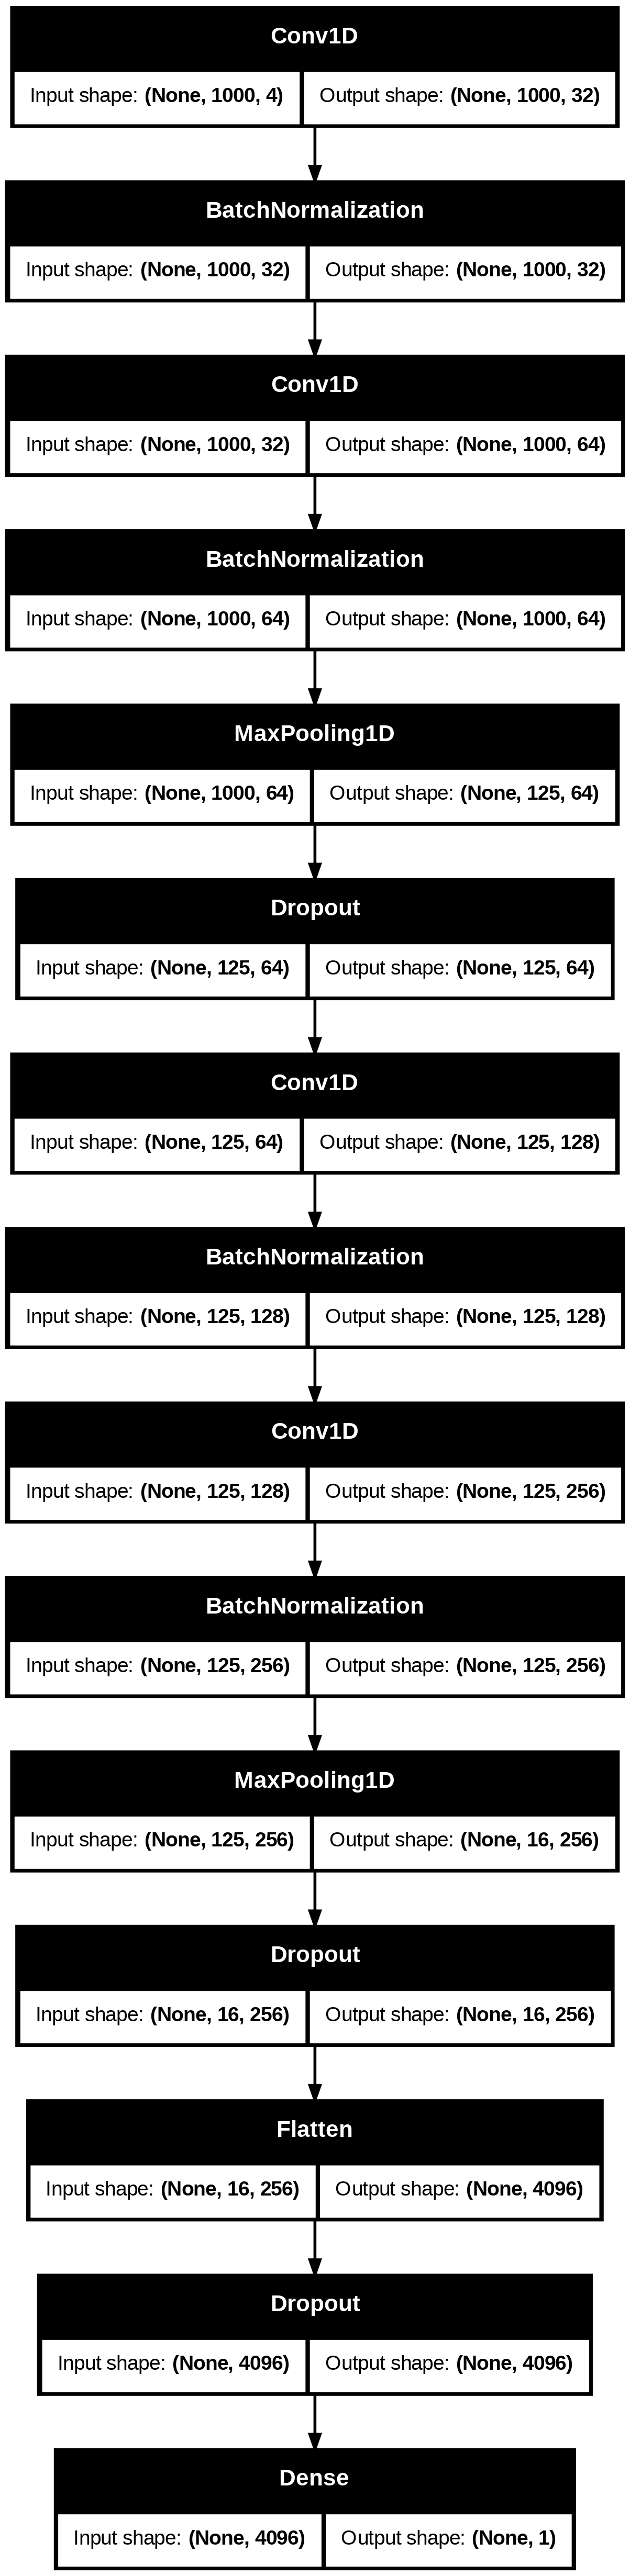

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model=model, show_shapes=True)

In [ ]:
model_history = model.fit(X_train, y_train, epochs=epochs,
                          batch_size=batch_size, validation_data=(X_valid,y_valid),
                          class_weight = class_weight,
                          #class_weight={0:0.001,1:0.999},
                          callbacks=call_back_list)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.5360 - loss: 0.8314 - prc: 0.5339 - val_accuracy: 0.4746 - val_loss: 1.2535 - val_prc: 0.7315
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6369 - loss: 0.6181 - prc: 0.6531 - val_accuracy: 0.4746 - val_loss: 1.9548 - val_prc: 0.7943
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7266 - loss: 0.4481 - prc: 0.7813 - val_accuracy: 0.4746 - val_loss: 3.2322 - val_prc: 0.6460
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7522 - loss: 0.3743 - prc: 0.8086 - val_accuracy: 0.4746 - val_loss: 3.2935 - val_prc: 0.6747
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7571 - loss: 0.3456 - prc: 0.8282 - val_accuracy: 0.4754 - val_loss: 3.0159 - val_prc: 0.7465
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7800 - loss: 0.3244 - prc: 0.8266 - val_accuracy: 0.4904 - val_loss: 2.4792 - val_prc: 0.8103
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
model.evaluate(X_test,y_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9267 - loss: 0.2253 - prc: 0.9680


[0.19383305311203003, 0.9783981442451477, 0.9405555725097656]

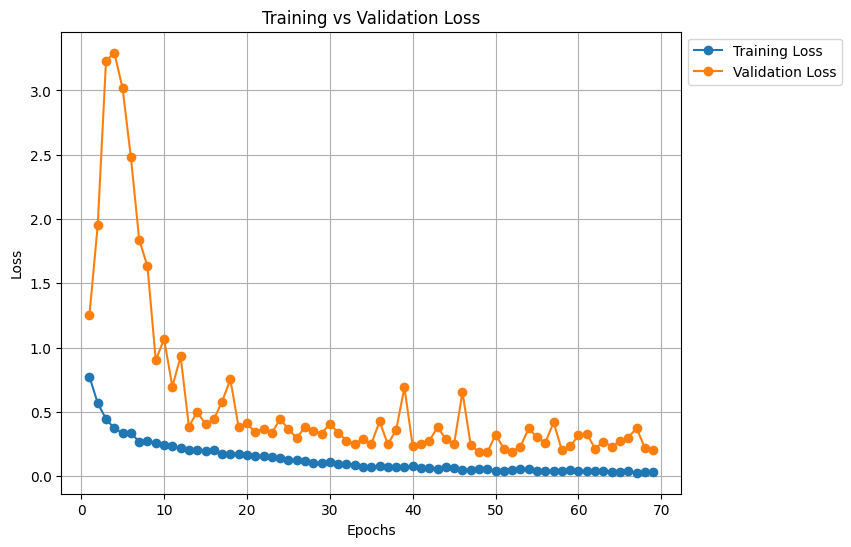

In [ ]:
loss_plot(model_history.history['loss'],model_history.history['val_loss'],Title="Training vs Validation Loss",legend_location="upper left",fig_size=(8, 6))

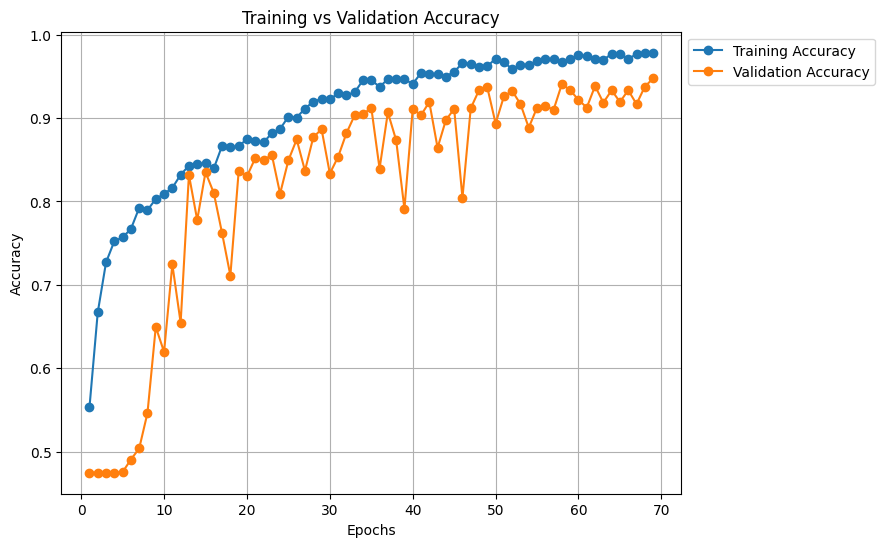

In [ ]:
Accuracy_plot(model_history.history['accuracy'],model_history.history['val_accuracy'],Title="Training vs Validation Accuracy",legend_location="upper left",fig_size=(8, 6))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


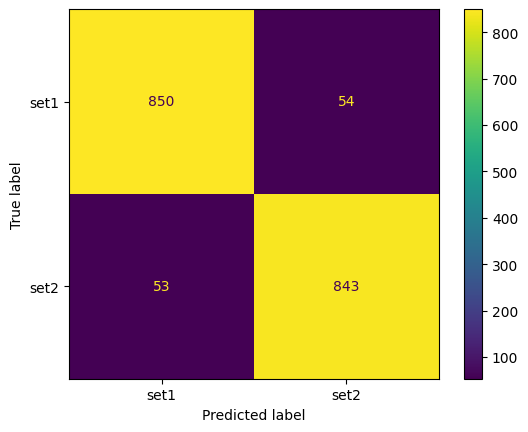

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


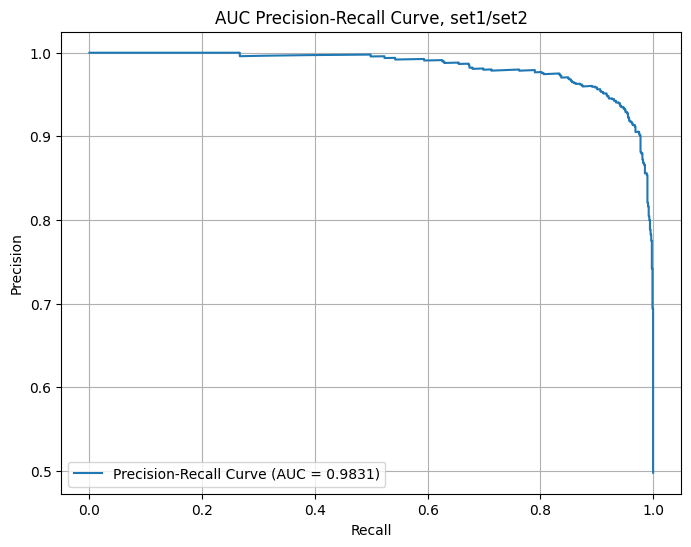

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


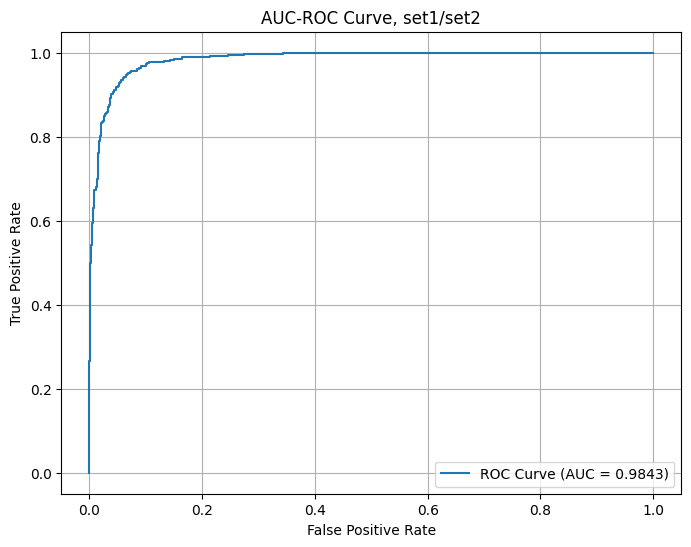

In [ ]:
import matplotlib.pyplot as plt
Binary_Confusion_Matrix(model,X_test,y_test,labelnames=labelnames)

AUC_Precision_Recall_Curve(model, X_test, y_test, fig_size =(8,6),Title=f'AUC Precision-Recall Curve, '+samples,xlabel='Recall',ylabel='Precision')
AUC_ROC_Curve(model, X_test, y_test, labels_keys=None, labels_values=None, fig_size=(8, 6),Title=f'AUC-ROC Curve, '+labelnames[0]+"/"+labelnames[1],xlabel='False Positive Rate',ylabel='True Positive Rate')

In [ ]:
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert to binary labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy, precision, recall, F1 score from confusion matrix
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()  # (TP + TN) / total
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])  # TP / (TP + FP)
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)  # Harmonic mean of precision and recall

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[850  54]
 [ 53 843]]
Accuracy: 0.9406
Precision: 0.9398
Recall: 0.9408
F1 Score: 0.9403


                                                                                                                                                                                                                                                                                        vb                                                                                                        